In [3]:
import xarray as xr
import os
import pandas as pd
import tqdm
import dask
import time
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
%matplotlib inline

In [21]:
# parameters cell
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/MASS/outdata/oifs/links_combined_with_SPIN/']

input_names = ['MASS']
climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
accumulation_period = 21600 # output frequency of OpenIFS in seconds
exps = range(1, 45)
figsize=(10, 5)
dpi = 200
var = ['SSR', 'STR', 'TSR', 'TTR', 'SLHF', 'SSHF'] 
#var must have order:  
#1. Surface net solar radiation
#2. Surface net thermal radiation
#3. Top net solar radiation
#4. Top net thermal radiation

In [19]:
# Calculates the point-wise equal-tail bootstrap P value rejecting equality of means
def bootstrap(xyobs, data1, data2):
    tstarobs = np.asarray(data2 - data1)
    tstar = []
    ta = []
    pvalue = []
    n = xyobs.shape[0]//2
    m = xyobs.shape[0]//2
    B = 20000

    for bi in tqdm(range(B)):
        t = dask.delayed(resample)(xyobs,n,m)
        ta.append(t)
    with ProgressBar():
        tstar = dask.compute(ta)
    tstar = np.squeeze(np.asarray(tstar), axis = 0)
    pvalue = np.empty((tstarobs.shape[0],tstarobs.shape[1]))
    for lat in tqdm(range(0,tstarobs.shape[0])):
        for lon in range(0,tstarobs.shape[1]):
            p1 = tstar[:,lat,lon][tstar[:,lat,lon] >= tstarobs[lat,lon]].shape[0]/B
            p2 = tstar[:,lat,lon][tstar[:,lat,lon] >= -tstarobs[lat,lon]].shape[0]/B
            pvalue[lat,lon] = min(p1,p2)
    return pvalue

# Inner loop used for bootstrap()
def resample(xyobs,n,m):
    xstar = []
    ystar = []
    for ni in range(n):
        r = rd.randrange(0, xyobs.shape[0])
        xstar.append(xyobs[r])
    for mi in range(m):
        r = rd.randrange(0, xyobs.shape[0])
        ystar.append(xyobs[r])
    xbarstar = np.mean(np.asarray(xstar),axis=0)
    ybarstar = np.mean(np.asarray(ystar),axis=0)
    t = xbarstar - ybarstar
    return t

# Returns equvalent to cdo yseasmean
def yseasmean(ds, calendar='standard'):
    dask.config.set({"array.slicing.split_large_chunks": True})
    month_length = ds.time.dt.days_in_month
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))
    return (ds * weights).groupby('time.season').sum(dim='time')

# Returns equvalent to cdo yearmean
def yearmean(ds):
    return ds.groupby('time.year').mean(dim='time')

# Returns equvalent to cdo fldmean
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))


In [20]:
# Load model Data

data = OrderedDict()
for v in var:
    start = time.time()
    print("reading", v)
    paths = []
    for exp in exps:
        paths.append(input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc')
        intermediate = []
        intermediate = xr.open_mfdataset(paths, combine="by_coords", engine="netcdf4", use_cftime=True)
        data[v] = intermediate.compute()
    end = time.time()
    print(end - start)

reading SSR
48.304211139678955
reading STR
43.71086001396179
reading TSR
43.19875645637512
reading TTR
42.946064472198486
reading SLHF
42.708035707473755
reading SSHF
42.711153984069824


In [14]:
# Load model Data


# Calculated weighted field means
fldm = OrderedDict()
for v in var:
    start = time.time()
    print("fldmean of", v)
    fldm[v] = fldmean(data[v].groupby('time.year').mean(dim='time'))
    end = time.time()
    print(end - start)

fldmean of SSR
0.7248167991638184
fldmean of STR
0.7314112186431885
fldmean of TSR
0.7625327110290527
fldmean of TTR
0.7324080467224121
fldmean of SLHF
0.7478251457214355
fldmean of SSHF
0.752178430557251


In [17]:
# Sum up TOA and SURF & calculate yearly means
surf = np.asarray(fldm['SSR'].to_array()) + \
       np.asarray(fldm['STR'].to_array())
toa = np.asarray(fldm['TSR'].to_array()) + \
      np.asarray(fldm['TTR'].to_array())

surf = surf/accumulation_period
toa = toa/accumulation_period

In [18]:
TTR_python = fldmean(data['TTR'])

In [19]:
np.asarray(TTR_python.to_array())

array([[[cftime.DatetimeProlepticGregorian(1850, 1, 1, 0, 0, 0, 0, has_year_zero=False),
         cftime.DatetimeProlepticGregorian(1850, 1, 31, 18, 0, 0, 0, has_year_zero=False)],
        [cftime.DatetimeProlepticGregorian(1850, 2, 1, 0, 0, 0, 0, has_year_zero=False),
         cftime.DatetimeProlepticGregorian(1850, 2, 28, 18, 0, 0, 0, has_year_zero=False)],
        [cftime.DatetimeProlepticGregorian(1850, 3, 1, 0, 0, 0, 0, has_year_zero=False),
         cftime.DatetimeProlepticGregorian(1850, 3, 31, 18, 0, 0, 0, has_year_zero=False)],
        [cftime.DatetimeProlepticGregorian(1850, 4, 1, 0, 0, 0, 0, has_year_zero=False),
         cftime.DatetimeProlepticGregorian(1850, 4, 30, 18, 0, 0, 0, has_year_zero=False)],
        [cftime.DatetimeProlepticGregorian(1850, 5, 1, 0, 0, 0, 0, has_year_zero=False),
         cftime.DatetimeProlepticGregorian(1850, 5, 31, 18, 0, 0, 0, has_year_zero=False)],
        [cftime.DatetimeProlepticGregorian(1850, 6, 1, 0, 0, 0, 0, has_year_zero=False),
      

In [20]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=21
    beta=20
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[10:len(y)-10]

NameError: name 'surface' is not defined

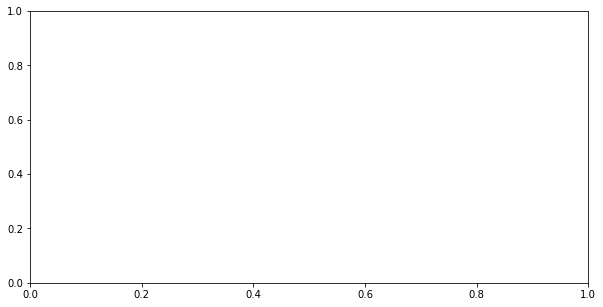

In [21]:
fig, axes = plt.subplots(figsize=figsize)

plt.plot(smooth(surface,len(surface)),color='blue')
plt.plot(smooth(toa,len(toa)),color='red')
plt.plot(smooth(toa-surface,len(toa-surface)),color='green')

plt.plot(surface,linewidth=0.5,color='blue')
plt.plot(toa,linewidth=0.5,color='red')
plt.plot(toa-surface,linewidth=0.5,color='green')


plt.axhline(y=0, color='black', linestyle='-')
plt.ylabel('W/m²')
plt.xlabel('Simulation Year')

axes.legend(['Net SFC', 'Net TOA', 'Net TOA - Net SFC'])

In [23]:
surf

array([[71.96902 , 72.16441 , 72.160095, 72.05589 , 72.02033 , 72.37209 ,
        71.825   , 72.187   , 72.09694 , 72.04967 , 71.80844 , 71.8544  ,
        72.01947 , 72.154755, 72.15606 , 72.195496, 71.895645, 72.017265,
        72.300545, 72.23211 ]], dtype=float32)